Mental health chatbot's deep learning model using LSTM based architecture


Importing Packages

In [1]:
import json
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re 

Loading the dataset

In [2]:
with open('data.json', 'r') as f:
    data = json.load(f)

In [3]:
df = pd.DataFrame(data['intents'])

In [4]:
dic = {"tag":[], "patterns":[], "responses":[]}
for i in range(len(df)):
    ptrns = df[df.index == i]['patterns'].values[0]
    rspns = df[df.index == i]['responses'].values[0]
    tag = df[df.index == i]['tag'].values[0]
    for j in range(len(ptrns)):
        dic['tag'].append(tag)
        dic['patterns'].append(ptrns[j])
        dic['responses'].append(rspns)

df = pd.DataFrame.from_dict(dic)

Developing a function to preprocess the text data

In [5]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub('\s+',' ',text)
    text = '[start]' + text + ' [end]'
    return text

In [6]:
X = df['patterns'].apply(preprocess)
y = df['tag']

Tokenizing the data to give a numeric value for model training

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index

max_sequence_length = max([len(seq) for seq in X_sequences])
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length)

Label Encoding the target responses 

In [9]:
LE = LabelEncoder()
y = LE.fit_transform(y)

Performing Training and Testing split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

LSTM based architecture

In [11]:
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=128, input_length=max_sequence_length))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(len(LE.classes_), activation='softmax'))

Model Parameters

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 128)           39040     
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 80)                10320     
                                                                 
Total params: 180,944
Trainable params: 180,944
Non-trainable params: 0
_________________________________________________________________


Training the model

In [13]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
6/6 [==============================] - 13s 407ms/step - loss: 4.3804 - accuracy: 0.0324 - val_loss: 4.3747 - val_accuracy: 0.0000e+00
Epoch 2/100
6/6 [==============================] - 0s 77ms/step - loss: 4.3493 - accuracy: 0.0595 - val_loss: 4.3552 - val_accuracy: 0.0000e+00
Epoch 3/100
6/6 [==============================] - 0s 61ms/step - loss: 4.2530 - accuracy: 0.0432 - val_loss: 4.3468 - val_accuracy: 0.0000e+00
Epoch 4/100
6/6 [==============================] - 0s 53ms/step - loss: 4.1110 - accuracy: 0.0649 - val_loss: 4.4205 - val_accuracy: 0.0213
Epoch 5/100
6/6 [==============================] - 0s 59ms/step - loss: 4.0524 - accuracy: 0.0541 - val_loss: 4.3106 - val_accuracy: 0.0213
Epoch 6/100
6/6 [==============================] - 0s 56ms/step - loss: 4.0341 - accuracy: 0.0486 - val_loss: 4.2705 - val_accuracy: 0.0213
Epoch 7/100
6/6 [==============================] - 0s 72ms/step - loss: 3.9528 - accuracy: 0.0757 - val_loss: 4.3255 - val_accuracy: 0.0213
Epoch 

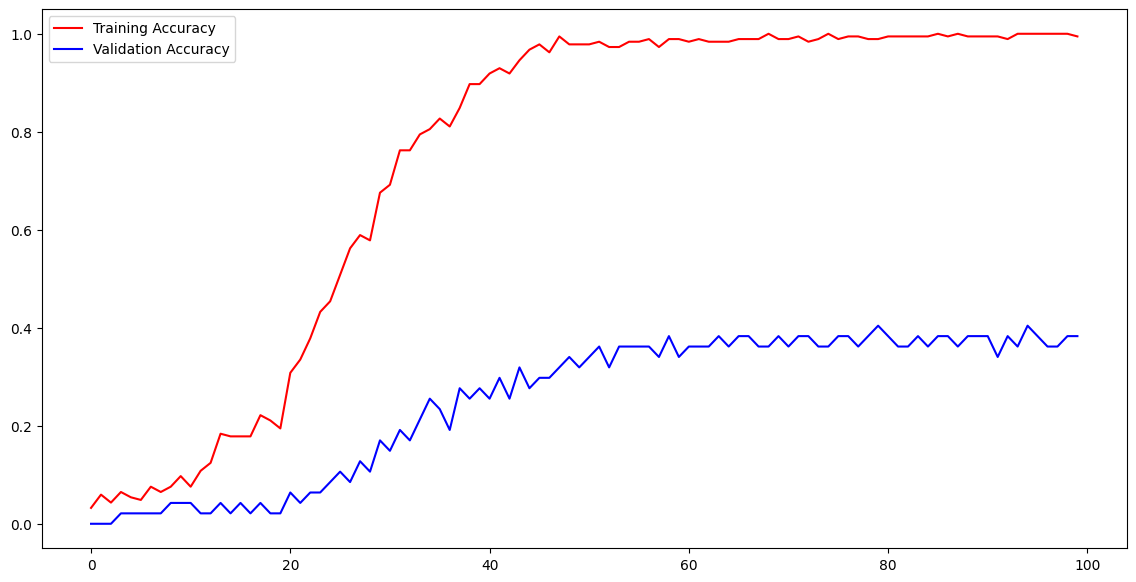

In [16]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.legend(loc='upper left')
plt.show()

A sample application of model that predicts the type of conversation and then responds to it with a predefined response

In [17]:
def predict_response(model, tokenizer, label_encoder, input_text, max_sequence_length):
    # Tokenize and pad the input text
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_padded = pad_sequences(input_seq, maxlen=max_sequence_length)
    
    # Predict the response
    predicted_prob = model.predict(input_padded)
    predicted_label = np.argmax(predicted_prob, axis=1)
    
    # Decode the predicted label to the actual response
    predicted_response = label_encoder.inverse_transform(predicted_label)
    print(predicted_response)
    return predicted_response[0]

input_text = "My name is XYZ"
predicted_response = predict_response(model, tokenizer, LE, input_text, max_sequence_length)
print(f"Input: {input_text}")
index = df.isin([predicted_response]).any(axis=1).idxmax()
new_response = random.choice(df['responses'].loc[index])

print(f"Response: {new_response}")


1/1 [==============================] - 1s 1s/step
['name']
Input: My name is XYZ
Response: Nice to meet you. So tell me. How do you feel today?


In [20]:
input_text = "I am not feeling good"
predicted_response = predict_response(model, tokenizer, LE, input_text, max_sequence_length)
print(f"Input: {input_text}")
index = df.isin([predicted_response]).any(axis=1).idxmax()
new_response = random.choice(df['responses'].loc[index])

print(f"Response: {new_response}")

1/1 [==============================] - 0s 67ms/step
['sad']
Input: I am not feeling good
Response: I'm sorry to hear that. I'm here for you. Talking about it might help. So, tell me why do you think you're feeling this way?


In [ ]:
def showLab(texti):
    Response_lab.config(text = texti)
    inputTxt.delete("1.0", "end-1c")

def inputButton(event):
    text = inputTxt.get("1.0", "end-1c")
    predicted_response = predict_response(model, tokenizer, LE, text, max_sequence_length)
    index = df.isin([predicted_response]).any(axis=1).idxmax()
    new_response = random.choice(df['responses'].loc[index])
    showLab(new_response)

In [ ]:
from tkinter import *

root = Tk()
root.geometry("600x400")
root.title("Chatbot Build 1")



#  3 Frames - title, Chats, TextInput
titleFrame = Frame(root, bg = "gray6")
chatsFrame = Frame(root, height=360, bg="gray9")
inputFrame = Frame(root, height=60)

Response_lab = Label(chatsFrame, text=" ", height=10, bg="gray9", fg="yellow", font='arial 14')

# Title Frame and thier Components
mainTitle = Label(titleFrame, text="The Chatbot", font="Helvetic 20 bold", bg="gray6", fg="darkOrchid1")
mainTitle.pack()

mainTitle = Label(titleFrame, text="How can I help You sir", font="Helvetic 14 bold", bg="gray6", fg="orchid1")
mainTitle.pack()
titleFrame.pack(fill=X)

# Label(chatsFrame, text="lklnknckj").pack()
Response_lab.pack()
chatsFrame.pack(fill=X)

inputTxt = Text(inputFrame, height=60, font="Arial 13", width=700, bg="gray12", fg="plum1")
inputTxt.bind('<Return>', inputButton)
inputTxt.pack()
inputFrame.pack(fill=X, side=BOTTOM)

root.mainloop()

1/1 [==============================] - 0s 29ms/step
['greeting']
1/1 [==============================] - 0s 29ms/step
['happy']
1/1 [==============================] - 0s 29ms/step
['happy']
1/1 [==============================] - 0s 28ms/step
['sad']
1/1 [==============================] - 0s 31ms/step
['hate-you']
1/1 [==============================] - 0s 28ms/step
['no-approach']
1/1 [==============================] - 0s 30ms/step
['casual']
1/1 [==============================] - 0s 29ms/step
['no-response']


In [ ]:
model.save(r"TheMainChatbot.h5")